# Homework for statistics module

In [103]:
import pandas as pd
import numpy as np
import scipy.stats as st
import math
import seaborn as sns
import plotly.graph_objects as go

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('bmh')

from pylab import rcParams
from scipy import stats

# plots in svg look more precise
%config InlineBackend.figure_format = 'svg'

!pip install pycodestyle
!pip install --index-url https://test.pypi.org/simple/ nbpep8

from nbpep8.nbpep8 import pep8


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://test.pypi.org/simple/, https://us-python.pkg.dev/colab-wheels/public/simple/


# Task 1

## Stratification

The example:

Let's assume, we need to estimate a mean votes count for every election candidate. Suppose there are 3 cities in a country: 1 million factory workers live in city A, 2 million office workers live in city B, and 3 million senior citizens live in city B. We can choose a random sample of 60 votes from the entire population, but there is some chance that the random sample will be poorly balanced between these cities and, therefore, will be biased and of little use ("average temperature in the hospital"), causing a significant error in the estimation. Instead, if we choose to use a simple random sample of 10, 20 and 30 votes from cities A, B and C, respectively, we can get a smaller error in the estimate with the same total sample size. This technique is called stratification.


### The task

Suppose the population is a mixture of 3 normally distributed CBs. In other words, the population can be divided into 3 strata.
$$
    F(X) = a_1 F(X_1) + a_2 F(X_2) + a_3 F(X_3)
$$

**Goals:**  

1. Derive (for example, in the block below, using Markdown) the formulas for point estimates of the mathematical expectation and variance for the average value of subsamples formed in different ways:
- random selection from the entire population;
- random selection of strata in proportion to strata volumes;
- random selection according to the optimal sub-sampling.

2. Calculate point estimates of the mathematical expectation and variance of the mean value for each data sampling method from p.1, provided:
* Experiments should be conducted for 3 cases (for every method from p.1 each):
     * all strata have the same mat. expectations and variance;
     * strata have different mat. expectations, but the same variance;
     * strata have different mat. expectations and variance.
* For each experiment plot histogram of General Population data (using matplotlib or seaborn packages);
* Plot boxplots for sample mean estimated using each sampling method on a single figure to compare the results. Repeat for each experiment.
* You are provided with `GeneralPopulation` class. It already has all necessary methods for sampling and creating general population as a mixture of strata.
* Your goal is to write functions to conduct experiments and visualize the results.   
* Also provide commentaries as summaries and analysis of results after each visualization.


## Solution for Task 1

### Formulas:

I like $W$ more than $α$, it looks better visually =)

#### Stratified sample point estimations:

$$F(x)=W_1F_1(x)+...+W_LF_L(x)$$
Where: $W_k$ - strata's ratio, L - number of stratas

Let:
$$μ=E[F(x)]$$
$$σ^2=D[F(x)]$$
$μ_k$ - Expected value of k'th strata 

$σ^2_k$ - Variance of the k'th strata

Expected value and variance:
$$μ=\int_{-\infty}^{+\infty}xF(x)\,dx=\int_{-\infty}^{+\infty}x[W_1F_1(x)+...+W_LF_L(x)]\,dx$$
$$\sigma^2=\int_{-\infty}^{+\infty}F(x)(x-μ)^2\,dx=\int_{-\infty}^{+\infty}[W_1F_1(x)+...+W_LF_L(x)](x-μ)^2\,dx$$

Within the kth strata let’s take a sample of volume $n_k$: 

$$(X_{1k},X_{2k},...,X_{nk})$$
Then its sample mean:
$$μ_k=\dfrac{1}{n_k}\sum_{i=1}^{n_k}X_{ik}$$
And its sample variance:
$$μ_k=\dfrac{1}{n_k-1}\sum_{i=1}^{n_k}(X_{ik}-μ_k)^2$$

If we are doing SRS, then we can use same formulae but assuming we have only one strata $L=1$

#### Sample volumes if they are sampled proportionally:

$$n_k=nW_k$$
Where:

n - overall number of samples $n=n_1+n_2+...+n_L$

#### Sample volumes if they are optimal sampled (Neyman's method):

$$n_k=n\dfrac{W_kσ_k}{\sum_{i=1}^{L}W_kσ_k}$$


### Point estimates calculation
**GeneralPopulation class**  
Already has methods for creating general population as a mixture of strata, for generating subsample with random, optimal and stratified techniques:

In [104]:
class GeneralPopulation:


  def __init__(self, 
               means: [float], 
               stds: [float], 
               sizes: [int], 
               random_state: int = 15
               ):
    """
    Initializes our General Population and saves the given distributions
    
    :param means: List of expectations for normal distributions
    :param stds: List of standard deviations for normal distributions
    :param sizes: How many objects will be in each strata
    :param random_state: Parameter fixing randomness. Needed so that when conducting
    experiment repeatedly with the same input parameters, the results remained the same
    """
    self.strats = [st.norm(mean, std) for mean, std in zip(means, stds)]
    self._sample(sizes)
    self.random_state = random_state

  def _sample(self, sizes):
        """Creates a general population sample as a mixture of strata
        
        :param sizes: List with sample sizes of the corresponding normal distributions
        """
        self.strats_samples = [rv.rvs(size) for rv, size in zip(self.strats, sizes)]
        self.general_samples = np.hstack(self.strats_samples)
        self.N = self.general_samples.shape[0]
        
        # number of strata
        self.count_strats = len(sizes)
        
        # ratios for every strata in GP
        self.ws = [size/self.N for size in sizes]
        
        # ME and Std for GP
        self.m = np.mean(self.general_samples)
        self.sigma = np.std(self.general_samples)
        
        # ME and std for all strata
        self.ms = [np.mean(strat_sample) for strat_sample in self.strats_samples]
        self.sigmas = [np.std(strat_sample) for strat_sample in self.strats_samples]

  def random_subsampling(self, size):
      """Creates a random subset of the entire population
      
      :param sizes: subsample size
      """
      rc = np.random.choice(self.general_samples, size=size) 
      return rc
      
  def proportional_subsampling(self, size):
      """Creates a subsample with the number of elements, proportional shares of 
      strata
      
      :param sizes: subsample size
      """
      self.strats_size_proport = [int(np.floor(size*w)) for w in self.ws]
      
      rc = []
      for k in range(len(self.strats_size_proport)):
          rc.append(np.random.choice(self.strats_samples[k],
                                      size=self.strats_size_proport[k]))
      
      return rc
      
  def optimal_subsampling(self, size):
      """Creates a subsample with the optimal number of elements relative to
      strata
    
      :param sizes: subsample size
      """
      sum_denom = 0
      for k in range(self.count_strats):
          sum_denom += self.ws[k] * self.sigmas[k]
      
      self.strats_size_optimal = [int(np.floor((size*w*sigma)/sum_denom)) for 
                                  w, sigma in zip(self.ws, self.sigmas)]


      if 0 in self.strats_size_optimal:
          raise ValueError('Strats size is 0, please change variance of smallest strat!')
      
      rc = []
      for k in range(len(self.strats_size_optimal)):
          rc.append(np.random.choice(self.strats_samples[k],
                                      size=self.strats_size_optimal[k]))
      
      return rc   

  def run_experiments(self, n_sub, subsampling_method, n_experiments=1000):
      """Conducts a series of experiments and saves the results
      
      :param subsampling_method: method for creating a subsample
      :param n_experiments: number of experiment starts
      """
      means_s = []
      
      if(len(self.general_samples) < 100):
          n_sub = 20
      
      if(subsampling_method == 'random_subsampling'):
          for n in range(n_experiments):
              rc = self.random_subsampling(n_sub)
              
              mean = rc.sum() / len(rc)
              means_s.append(mean)
              
      else:
          for n in range(n_experiments):
              if(subsampling_method == 'proportional_subsampling'):
                  rc = self.proportional_subsampling(n_sub)
              elif(subsampling_method == 'optimal_subsampling'):
                  rc = self.optimal_subsampling(n_sub)
              
              strats_mean = []
      
              for k in range(len(rc)):
                  strats_mean.append(sum(rc[k]) / len(rc[k]))
      
              # Mean for a mixture
              means_s.append(sum([w_k*mean_k for w_k, mean_k in 
                                  zip(self.ws, strats_mean)]))
              
      return means_s

Function for histogram plot:

In [105]:
"""HERE IS YOUR CODE
It should be implemented as follows:
* Takes a GeneralPopulation class instance;
* Uses matplotlib or seaborn packages to plot distribution for general population;
* Don't forget a title, grid etc. 
"""
def plot_hist(pop, population_type: str):

  from matplotlib.ticker import MaxNLocator

  if population_type == 'general':
    sns.displot(pop.general_samples)
    plt.title('Distribution of the general population')
    plt.xlabel('Value')
    plt.show()
    
  if population_type == 'stratified':
    lists = pop.strats_samples
    df = pd.concat([pd.Series(x) for x in lists], axis=1)
    ax = sns.displot(data=df)
    plt.xlabel('Value')
    ax._legend.set_title('Strata')
    plt.show()

Function for plotting Boxplots for sample mean:

In [106]:
"""HERE IS YOUR CODE
It should be implemented as follows:
* Takes a GeneralPopulation class instance;
* Runs method `run_experiments` for each sampling method and gets vector of mean values;
* Uses matplotlib or seaborn packages to plot boxplots of mean values for each subsampling techniques;
* Axis Y == Mean values; Axis X == subsampling methods;
* Don't forget a title, grid etc. 
"""
def plot_boxplot(pop, population_type: str):

  if population_type == 'general':
    sns.boxplot(data=pop.general_samples)
    plt.title('Distribution of the general population')
    plt.xlabel('Value')
    plt.show()

  if population_type == 'stratified':
    lists = pop.strats_samples
    df = pd.concat([pd.Series(x) for x in lists], axis=1)
    sns.boxplot(data=df)
    plt.title('Distribution by stratas')
    plt.xlabel('Strata')
    plt.ylabel('Value')
    plt.show()
  
  if population_type == 'means':
    means={}
    means['random_subsampling']=pop.run_experiments(50, 'random_subsampling')
    means['proportional_subsampling']=pop.run_experiments(50, 'proportional_subsampling')
    means['optimal_subsampling']=pop.run_experiments(50, 'optimal_subsampling')
    df = pd.DataFrame(means)
    sns.boxplot(data=df)
    plt.title('Mean values for each subsampling techniques')
    plt.xticks(rotation=45)
    plt.xlabel('Sampling technique type')
    plt.ylabel('Sample mean')
    plt.show()

**Parameters for each General Population**  
You can use these or specify your own parameters for strata:

In [107]:
SIZES = (500, 500, 500)
N_SUBSAMPLE = 150
EQUAL_MEAN_EQUAL_STDS_ARGS = {'means': [0, 0, 0], 'stds': [3, 3, 3], 'sizes': SIZES}
DIFFERENT_MEAN_EQUAL_STDS_ARGS = {'means': [15, -1, -17], 'stds': [3, 3, 3], 'sizes':SIZES}
EQUAL_MEAN_DIFFERENT_STDS_ARGS = {'means': [0, 0, 0], 'stds': [3, 7, 11], 'sizes':SIZES}

**Initialization**

In [108]:
# Create GeneralPopulation class instances here
population_1 = GeneralPopulation(EQUAL_MEAN_EQUAL_STDS_ARGS['means'], 
                                 EQUAL_MEAN_EQUAL_STDS_ARGS['stds'],
                                 EQUAL_MEAN_EQUAL_STDS_ARGS['sizes'])
population_2 = GeneralPopulation(DIFFERENT_MEAN_EQUAL_STDS_ARGS['means'], 
                                 DIFFERENT_MEAN_EQUAL_STDS_ARGS['stds'],
                                 DIFFERENT_MEAN_EQUAL_STDS_ARGS['sizes'])
population_3 = GeneralPopulation(EQUAL_MEAN_DIFFERENT_STDS_ARGS['means'], 
                                 EQUAL_MEAN_DIFFERENT_STDS_ARGS['stds'],
                                 EQUAL_MEAN_DIFFERENT_STDS_ARGS['sizes'])

#### **General population with EQUAL means and EQUAL STDs of strata**  

##### **Histogram of the whole population:**

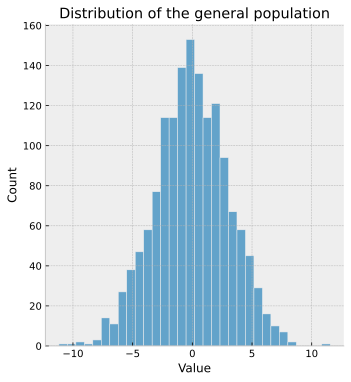

In [109]:
# Run plotting for density
plot_hist(population_1, 'general')

Distribution looks very close to normal

##### **Histogram of the population by strata:**

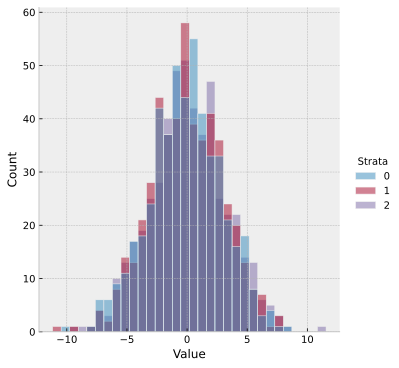

In [110]:
# Run plotting for density
plot_hist(population_1, 'stratified')

We can see that distributions of population by strata are the same.

##### **Boxplot of the whole population:**

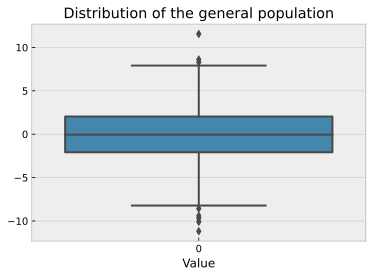

In [111]:
# Run plotting for boxplots
plot_boxplot(population_1, 'general')

We can see that distribution is very symmetric (same as the histogram) and there are a couple of potential outliers. 

##### **Boxplots of the population by stratas:**

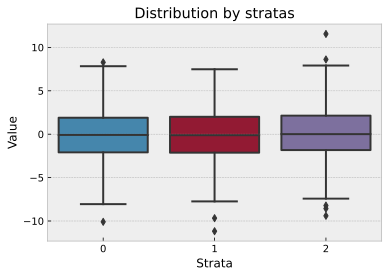

In [112]:
# Run plotting for boxplots
plot_boxplot(population_1, 'stratified')

We can see that despite all params are equal, due to randomnes we have a slightly different distributions

##### **Boxplots for sample means:**

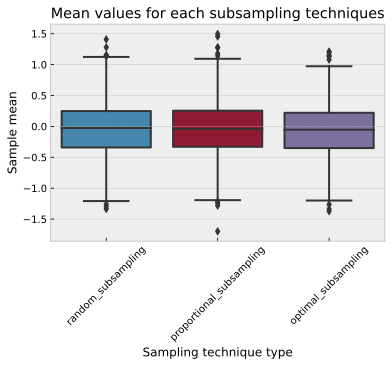

In [113]:
plot_boxplot(population_1, 'means')

We can see that despite all params are equal, due to randomnes we have a slightly different distributions of sample means

#### **General population with DIFFERENT means and EQUAL STDs of strata**  


##### **Histogram of the whole population:**

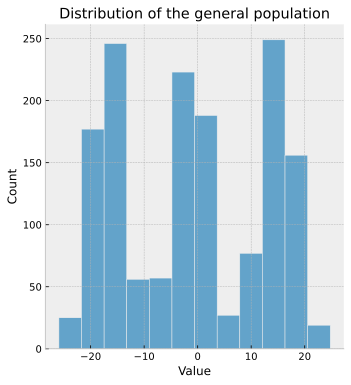

In [114]:
# Run plotting for density
plot_hist(population_2, 'general')

We can see here that the distribution has three modes

##### **Histogram of the population by strata:**

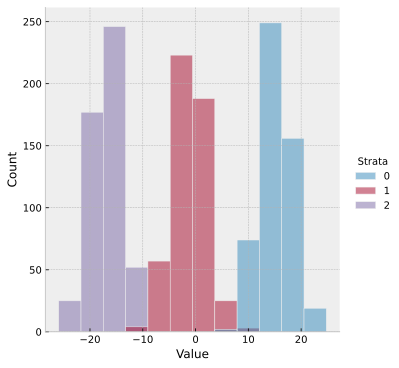

In [115]:
# Run plotting for density
plot_hist(population_2, 'stratified')

And here we can see why - it's three very different distributions with same variance and different means

##### **Boxplot of the whole population:**

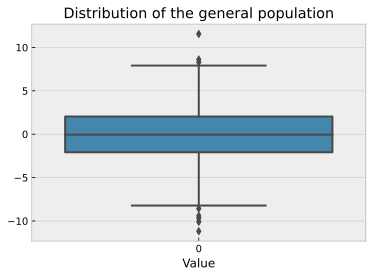

In [116]:
# Run plotting for boxplots
plot_boxplot(population_1, 'general')

We can see that general population distribution has median of 0, which is not representative at all

##### **Boxplots of the population by stratas:**


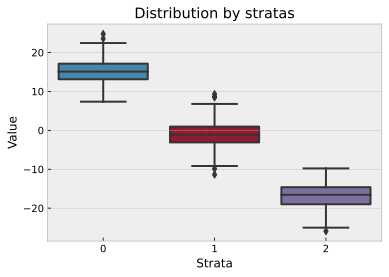

In [117]:
# Run plotting for boxplots
plot_boxplot(population_2, 'stratified')

We can see it clearly here - the strata distributions has different means and same variance

##### **Boxplots for sample means:**

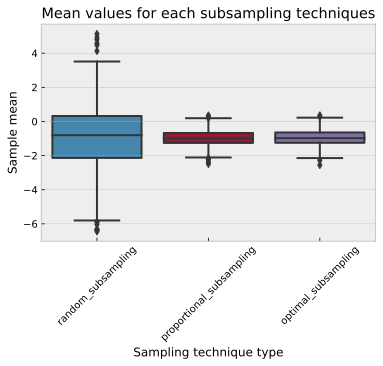

In [118]:
plot_boxplot(population_2, 'means')

Not representative of the population

**General population with DIFFERENT means and DIFFERENT STDs of strata**  
Distribution histogram:

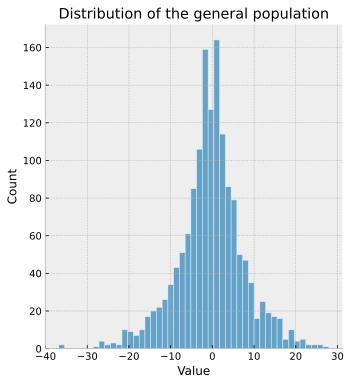

In [119]:
# Run plotting for density
plot_hist(population_3, 'general')

Looks more like t-distribution

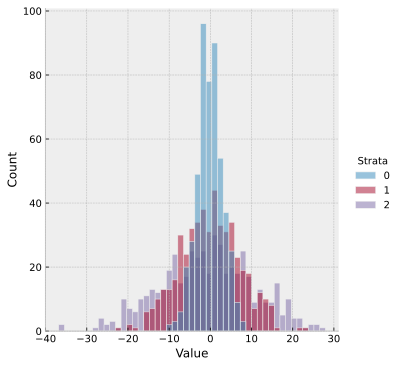

In [120]:
# Run plotting for density
plot_hist(population_3, 'stratified')

Here we can see a composition

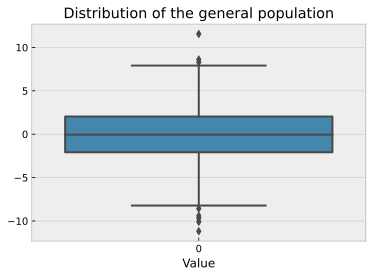

In [121]:
# Run plotting for boxplots
plot_boxplot(population_1, 'general')

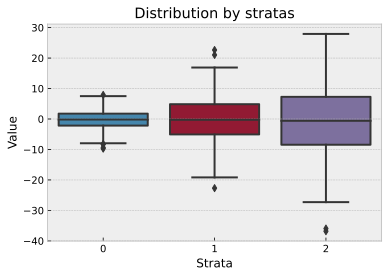

In [122]:
# Run plotting for boxplots
plot_boxplot(population_3, 'stratified')

We can see how 3 populations with different variance merge into one wide distribution

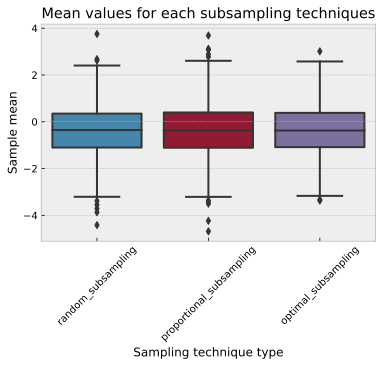

In [123]:
plot_boxplot(population_3, 'means')

Boxplots for sample mean:

With the experiments conducted and statistics estimated we can generate these <b>conclusions</b>: 

We can see that if our population has different stratas with different distributions we must use stratified sampling for our samples be representative

# Task 2



### Part 1
Using [this criteria](https://support.minitab.com/en-us/minitab-express/1/help-and-how-to/modeling-statistics/regression/how-to/correlation/interpret-the-results/#:~:text=For%20the%20Pearson%20correlation%2C%20an,linear%20relationship%20between%20the%20variables.&text=If%20both%20variables%20tend%20to,represents%20the%20correlation%20slopes%20upward.), check whether there is a correlation between a brain size and intelligence for a dataset consisted both of men and women objects. Also check it for men and women subsamples separately.


### Part 2
Using $Chi^2$ criteria check whether there is a statistical difference between men's and women's choice of auto.  (Features `Sex` и `PreferCar`)


You can download dataset using the following:

In [124]:
!pip install bds_courseware
from bds_courseware import read_drive_dataset
from bds_courseware import HOMEWORK_DATASETS
brain_data = read_drive_dataset(*HOMEWORK_DATASETS['brain'])  # PART 1
cars_prefes_data = read_drive_dataset(*HOMEWORK_DATASETS['car_perfs'])  # PART 2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [125]:
display(brain_data.head())

,Gender,FSIQ,VIQ,PIQ,Weight,Height,MRI_Count
0,Female,133,132,124,118,64.5,816932
1,Male,140,150,124,�,72.5,1001121
2,Male,139,123,150,143,73.3,1038437
3,Male,133,129,128,172,68.8,965353
4,Female,137,132,134,147,65.0,951545


There are some problems with data in `Weight` column

In [126]:
brain_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Gender     40 non-null     object
 1   FSIQ       40 non-null     int64 
 2   VIQ        40 non-null     int64 
 3   PIQ        40 non-null     int64 
 4   Weight     40 non-null     object
 5   Height     40 non-null     object
 6   MRI_Count  40 non-null     int64 
dtypes: int64(4), object(3)
memory usage: 2.3+ KB


In [127]:
brain_data['Weight'] = pd.to_numeric(brain_data['Weight'],errors='coerce')

In [128]:
display(brain_data.head())

,Gender,FSIQ,VIQ,PIQ,Weight,Height,MRI_Count
0,Female,133,132,124,118.0,64.5,816932
1,Male,140,150,124,NaN,72.5,1001121
2,Male,139,123,150,143.0,73.3,1038437
3,Male,133,129,128,172.0,68.8,965353
4,Female,137,132,134,147.0,65.0,951545


Much better

Let's see coorelation visually not diving by sex

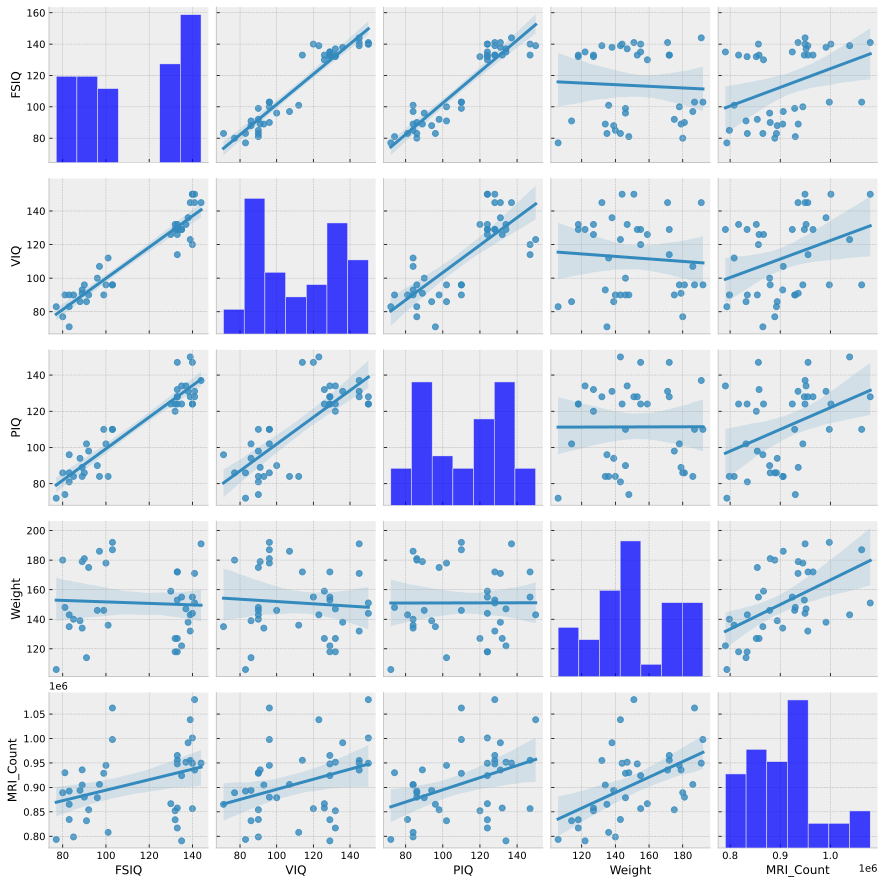

In [129]:
sns.pairplot(data=brain_data, kind="reg")
plt.show()

We can see some variables has strong correlations. Let's see Pearson's correlations

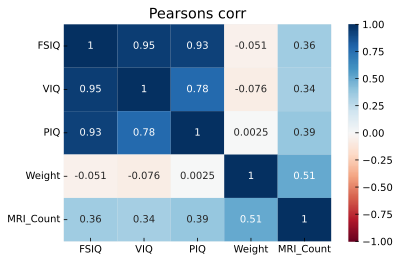

In [130]:
corr_table = brain_data.corr(method='pearson')
sns.heatmap(corr_table, cmap='RdBu', annot=True, vmin=-1, vmax=1)
plt.title('Pearsons corr')
plt.show()

Let's see Spearman's correlations:

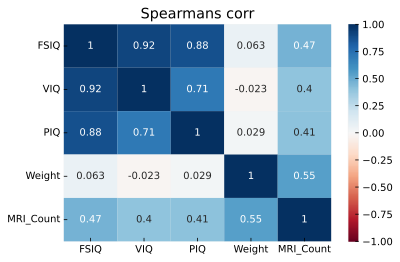

In [131]:
corr_table = brain_data.corr(method='spearman')
sns.heatmap(corr_table, cmap='RdBu', annot=True, vmin=-1, vmax=1)
plt.title('Spearmans corr')
plt.show()

We can see here that `Weight` has medium correlation only with `MRI_Count` which is logical

Let's divide by gender:

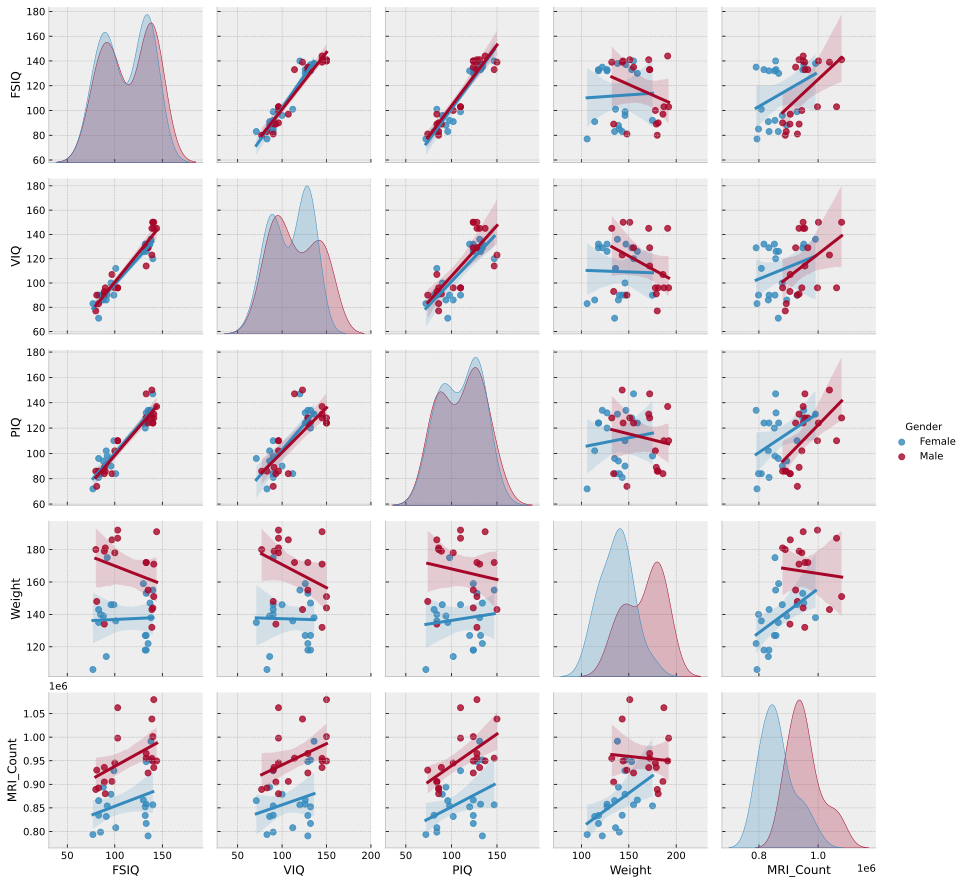

In [132]:
sns.pairplot(data=brain_data, hue='Gender', kind="reg")
plt.show()

Let's see numerical Pearson's by gender

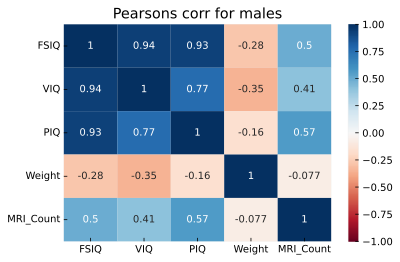

In [133]:
corr_table = brain_data[brain_data['Gender']=='Male'].corr(method='pearson')
sns.heatmap(corr_table, cmap='RdBu', annot=True, vmin=-1, vmax=1)
plt.title('Pearsons corr for males')
plt.show()

Weak negative corrlation

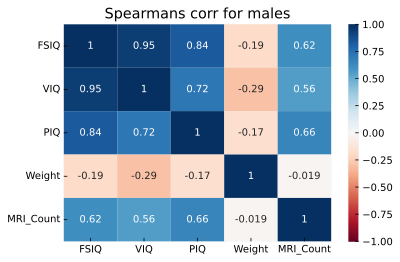

In [134]:
corr_table = brain_data[brain_data['Gender']=='Male'].corr(method='spearman')
sns.heatmap(corr_table, cmap='RdBu', annot=True, vmin=-1, vmax=1)
plt.title('Spearmans corr for males')
plt.show()

Same weak negative. Let's check for females

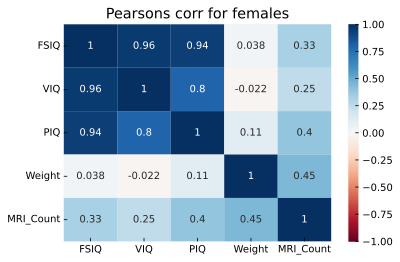

In [135]:
corr_table = brain_data[brain_data['Gender']=='Female'].corr(method='pearson')
sns.heatmap(corr_table, cmap='RdBu', annot=True, vmin=-1, vmax=1)
plt.title('Pearsons corr for females')
plt.show()

I would say it's nothing

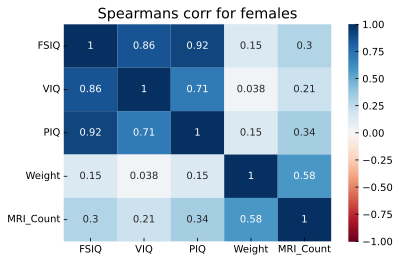

In [136]:
corr_table = brain_data[brain_data['Gender']=='Female'].corr(method='spearman')
sns.heatmap(corr_table, cmap='RdBu', annot=True, vmin=-1, vmax=1)
plt.title('Spearmans corr for females')
plt.show()

Weak positive coorelation for `FSIQ` and `PIQ`

## Part 2

In [137]:
table = pd.crosstab(cars_prefes_data['Sex'], cars_prefes_data['PreferCar'])
display(table)

PreferCar,1,2,3,4
Sex,,,,
1,43,75,26,6
2,25,61,47,17


In [138]:
stats.chi2_contingency(table)

(17.507847808569526, 0.0005555699275518034, 3, array([[34. , 68. , 36.5, 11.5],
        [34. , 68. , 36.5, 11.5]]))

The first value (17.5) is the Chi-square value, followed by the p-value (5.56e-04), then comes the degrees of freedom (3), and lastly it outputs the expected frequencies as an array. Since all of the expected frequencies are greater than 5, the chi2 test results can be trusted. We can reject the null hypothesis as the p-value is less than 0.05. Thus, the results indicate that there is a relationship between sex and car choice. 

# Task 3

You can find and download a dataset there:
https://www.kaggle.com/russellyates88/suicide-rates-overview-1985-to-2016


1) For any country (you are free to choose any of the presented) 
 *  Visualize a feature **suicides_no** considering other features: **sex**, **age** (or **generation**) and year;
 *  Check whether there is statistical difference for suicide number between these groups: men / women. If it is found, can we claim that people of certain sex are more prone to suicides or do we need additional information?

2) For 2016: divide countries into 3-4 groups according to the values of the **gdp_per_capita** feature (use statistical characteristics to determine how to divide the data into groups), check if the suicides / 100k pop indicator differs in these groups. Do not forget that for each country you have several values and they need to be aggregated or checked for each group separately.

In [139]:
df = pd.read_csv('https://raw.githubusercontent.com/Myoth13/datasets/main/suicide.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27820 entries, 0 to 27819
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   country             27820 non-null  object 
 1   year                27820 non-null  int64  
 2   sex                 27820 non-null  object 
 3   age                 27820 non-null  object 
 4   suicides_no         27820 non-null  int64  
 5   population          27820 non-null  int64  
 6   suicides/100k pop   27820 non-null  float64
 7   country-year        27820 non-null  object 
 8   HDI for year        8364 non-null   float64
 9    gdp_for_year ($)   27820 non-null  object 
 10  gdp_per_capita ($)  27820 non-null  int64  
 11  generation          27820 non-null  object 
dtypes: float64(2), int64(4), object(6)
memory usage: 2.5+ MB


In [140]:
pd.concat([df[:2], df[10000:10002], df[-2:]])

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent
10000,Germany,2014,male,35-54 years,2444,11949414,20.45,Germany2014,0.916,"3,890,606,893,347",50167,Generation X
10001,Germany,2014,male,25-34 years,750,5179803,14.48,Germany2014,0.916,"3,890,606,893,347",50167,Millenials
27818,Uzbekistan,2014,female,5-14 years,44,2631600,1.67,Uzbekistan2014,0.675,"63,067,077,179",2309,Generation Z
27819,Uzbekistan,2014,female,55-74 years,21,1438935,1.46,Uzbekistan2014,0.675,"63,067,077,179",2309,Boomers


Some data preparation

In [141]:
df.loc[:, 'age'] = df['age'].str.replace(' years','')
df.loc[df['age'] == '5-14', 'age'] = '05-14'
pd.concat([df[:2], df[10000:10002], df[-2:]])


,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent
10000,Germany,2014,male,35-54,2444,11949414,20.45,Germany2014,0.916,"3,890,606,893,347",50167,Generation X
10001,Germany,2014,male,25-34,750,5179803,14.48,Germany2014,0.916,"3,890,606,893,347",50167,Millenials
27818,Uzbekistan,2014,female,05-14,44,2631600,1.67,Uzbekistan2014,0.675,"63,067,077,179",2309,Generation Z
27819,Uzbekistan,2014,female,55-74,21,1438935,1.46,Uzbekistan2014,0.675,"63,067,077,179",2309,Boomers


Looks alright

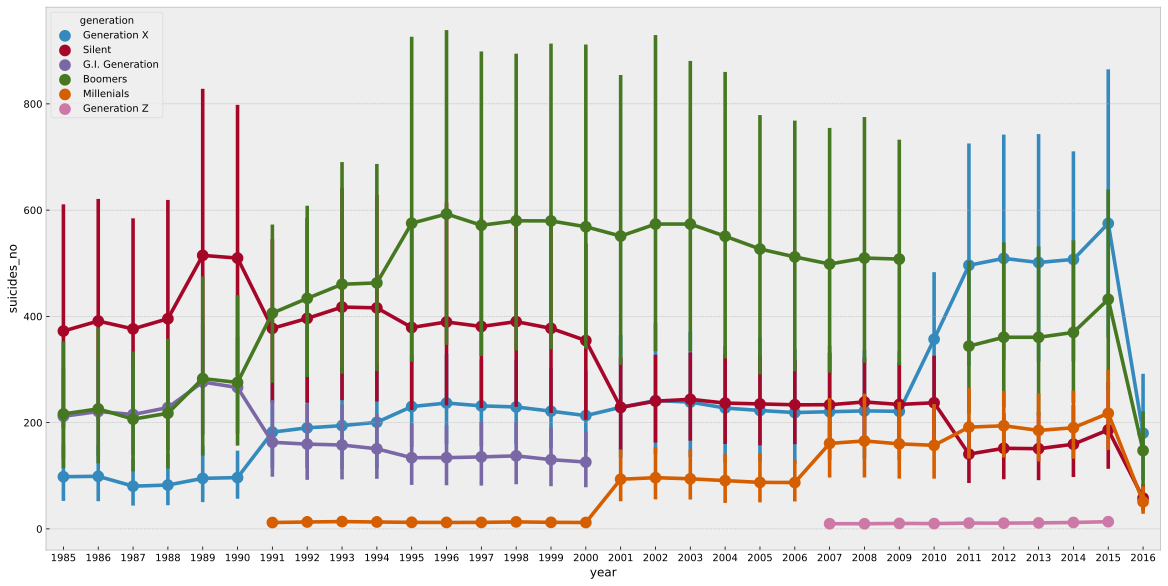

In [142]:
ax = plt.subplots(figsize=(20,10))
sns.pointplot(y='suicides_no', x='year', hue='generation',data=df)
plt.show()

Looks messy but it's the best that I could get 

In [143]:
print(df.loc[df['sex']=='male'].suicides_no.std())
print(df.loc[df['sex']=='female'].suicides_no.std())

1217.448508051167
333.4912243819031


we can see that variance are different so I'm going to use Welch’s t-Test

In [144]:
stats.ttest_ind(df.loc[df['sex']=='male'].suicides_no, df.loc[df['sex']=='female'].suicides_no, equal_var=False)


Ttest_indResult(statistic=24.378626630539273, pvalue=6.4421074798191e-129)

Result is significant, so we can reject the null hypothesis that suicides rate are independent from gender. 
Let's see GDP the data by country

In [145]:
gdp2016 = df[df['year']==2016].groupby('country')[['gdp_per_capita ($)','suicides/100k pop']].mean()
gdp2016

,gdp_per_capita ($),suicides/100k pop
country,,
Armenia,3788.0,4.056
Austria,46976.0,18.323
Croatia,12905.0,21.356
Cyprus,25098.0,4.715
Czech Republic,19505.0,16.176
Grenada,10838.0,0.000
Hungary,13448.0,24.134
Iceland,64708.0,13.807
Lithuania,15742.0,36.172


In [146]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=3)
labels = km.fit(gdp2016['GDP'].values.reshape(-1, 1))


KeyError: ignored

In [ ]:
centroids = km.cluster_centers_
df2016=gdp2016
df2016['label'] = labels.labels_
df2016.reset_index(inplace=True)
df2016.columns=['Country','GDP','Suicides','Label']
display(df2016)

In [ ]:
sns.scatterplot(x='Suicides', y='GDP', hue='Label', data=df2016)
plt.title('Kmeans clustering')
plt.show()

We can see that dividing countries into two clusters based on ther GDP looks sensible, but in the task written that should be 3-4, so I will use three groups. Than I will use ANOVE to see if the GDP difference is statistically significant (visually there is no correlation)

In [ ]:
samples = [gr[1].values for gr in df2016.groupby('Label')['Suicides']]
f_val, p_val = stats.f_oneway(*samples)
print(f'F value: {f_val:.3f}, p value: {p_val}')


Huge p-value - we can not reject the null hypothesis that suicide rate is dependent on GDP. 

Score:
Evaluation criteria (66/100% in total)

Task 1 (30% max)
1. Requested formulas are provided (5%)
2. All necessary experiments are done (10%)
3. Results are analysed with commentaries (8%)

Tasks 2.1 и 2.2 (40% max)
1. Visualization and/or simple exploratory data analysis are implemented (5% * 2 tasks)
2. Hypotheses are tested (5%)
3. Results are analysed with commentaries (10%)

Task 3 (25% max)
1. Visualization and/or simple exploratory data analysis are implemented (5%)
2. Hypotheses are tested (3%)
3. Data was aggregated properly (5%)
4. Results are analysed with commentaries (3%)

Extra points (5% max)
1. +2% in case clear, "pythonic" and understandable code style